In [141]:
using Revise
using BenchmarkTools
using Plots
using HDF5

In [142]:
includet("measure_mc.jl")
includet("mcmc.jl")
includet("mk_Jij.jl")

  0.043891 seconds (5.20 k allocations: 258.735 KiB)


In [143]:
L = 9
num_spins = 3L^2
num_triangles = L^2

pos_to_spin_idx = mk_kagome(L)
;

## Spin positions on the square lattice

In [144]:
# Positions in spin_pos are defined on the square lattice (lattice constant=1)
spin_pos = Vector{Tuple{Int,Int}}(undef, num_spins)
for (k, v) in pos_to_spin_idx
    spin_pos[v] = k
end
spin_pos;

## Triangles

In [145]:
utriangles, dtriangles = mk_triangles(L)
#Convert Vector{Any} to 
utri = Vector{Vector{Int}}(utriangles)
dtri = Vector{Vector{Int}}(dtriangles)
triangles = vcat(utri, dtri);

## Definition of lattice

In [146]:
function get_reciprocal_basis_2d(a1,a2)
    b1, b2 = get_reciprocal_basis_3d(vcat(a1, 0.0), vcat(a2, 0.0), [0.0, 0.0, 1.0] )
    b1[1:2], b2[1:2]
end

function get_reciprocal_basis_3d(a1,a2,a3)
	b1 = 2π*(a2×a3)/(abs(a1 ⋅ (a2×a3)))
	b2 = 2π*(a3×a1)/(abs(a2 ⋅ (a3×a1)))
	b3 = 2π*(a1×a2)/(abs(a3 ⋅ (a1×a2)))
	return b1, b2
end

a1 = [1.0, 0.0]
a2 = [-0.5, sqrt(3)/2]
b1, b2 = get_reciprocal_basis_2d(a1,a2)

([6.283185307179586, 3.6275987284684357], [0.0, 7.255197456936871])

## Compute positions of spins in real space

In [147]:
spin_pos_rs = [0.5*p[1]*a1 + 0.5*p[2]*a2 for p in spin_pos]
;

## Fourie transform of spins for sqrt(3)xsqrt(3)

In [148]:
# It is important to keep computational complexity O(num_spins)
function ss2(q,kagome,spins,triangles)
  @assert length(keys(kagome)) == length(spins)
	
	sq = fill((0.0+0im,0.0+0im,0.0+0im),3)
    for it in triangles
        for j in 1:3
			idx = it[j]
			R = kagome[idx]
            sq[j] = sq[j] .+ spins[idx] .* exp((q⋅R)*im)
        end
    end
    
    ss = 0.0
	for i in 1:3
		ss += sq[i] ⋅ sq[i]
	end
	
	return ss /(3*length(triangles)^2)
end

ss2 (generic function with 1 method)

In [149]:
spins = mk_sqrt3(L)

243-element Array{Tuple{Float64,Float64,Float64},1}:
 (2.57237725884603e-15, 1.0, 0.0)
 (0.8660254037844367, -0.5000000000000034, 0.0)
 (-0.8660254037844393, -0.49999999999999895, 0.0)
 (2.57237725884603e-15, 1.0, 0.0)
 (0.8660254037844367, -0.5000000000000034, 0.0)
 (-0.8660254037844393, -0.49999999999999895, 0.0)
 (2.57237725884603e-15, 1.0, 0.0)
 (0.8660254037844367, -0.5000000000000034, 0.0)
 (-0.8660254037844393, -0.49999999999999895, 0.0)
 (-0.8660254037844394, -0.4999999999999987, 0.0)
 (0.8660254037844367, -0.5000000000000034, 0.0)
 (-7.354070601250002e-16, 1.0, 0.0)
 (-0.8660254037844393, -0.49999999999999895, 0.0)
 ⋮
 (0.8660254037844368, -0.5000000000000032, 0.0)
 (2.57237725884603e-15, 1.0, 0.0)
 (-0.8660254037844394, -0.4999999999999987, 0.0)
 (0.8660254037844378, -0.5000000000000014, 0.0)
 (2.3274478990165594e-15, 1.0, 0.0)
 (-0.8660254037844393, -0.49999999999999895, 0.0)
 (0.8660254037844368, -0.5000000000000032, 0.0)
 (2.57237725884603e-15, 1.0, 0.0)
 (-0.8660254037844

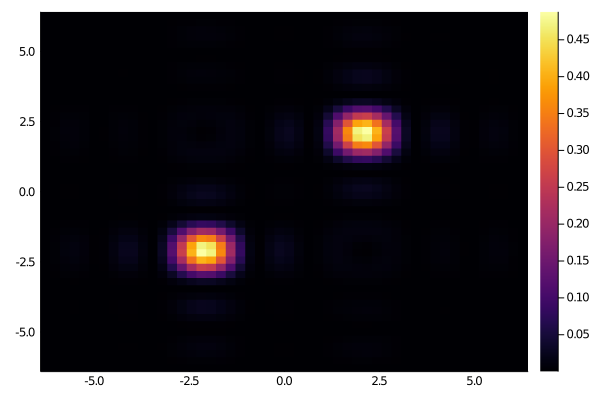

In [159]:
num_q = 50
q1s = LinRange(0, 1, num_q)
q2s = LinRange(0, 1, num_q)
ss_val = Float64[]
for i in 1:num_q,j in 1:num_q
	q = q1s[i]*b1 + q2s[j]*b2
	push!(ss_val, ss2((q[1],q[2]),spin_pos_rs, spins, triangles))
end
heatmap(qxs,qys,reshape(ss_val', num_q, num_q)) 

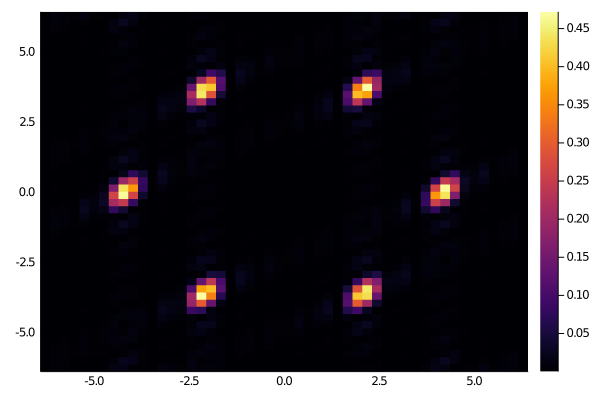

In [160]:
num_q = 50
qmax = 2π
qxs = LinRange(-qmax, qmax, num_q)
qys = LinRange(-qmax, qmax, num_q)

ss_val = Float64[]
for i in 1:num_q,j in 1:num_q
	push!(ss_val, ss2((qxs[i],qys[j]),spin_pos_rs, spins, triangles))
end
heatmap(qxs,qys,reshape(ss_val', num_q, num_q)) 

## si * sj

In [152]:
sisj = compute_sisj(1, spins, triangles)
size(sisj)

(243, 3, 1)

In [153]:
function compute_sq(q, kagome, sisj, triangles, idx_sbl, jtri)
    sq = 0.0+0im
    R_j = triangles[jtri][idx_sbl]
    for it in triangles
        ispin = it[idx_sbl]
        R = kagome[ispin] .- R_j 
        sq += sisj[ispin, idx_sbl, jtri] .* exp((q⋅R)*im)
    end
    sq
end

compute_sq (generic function with 1 method)

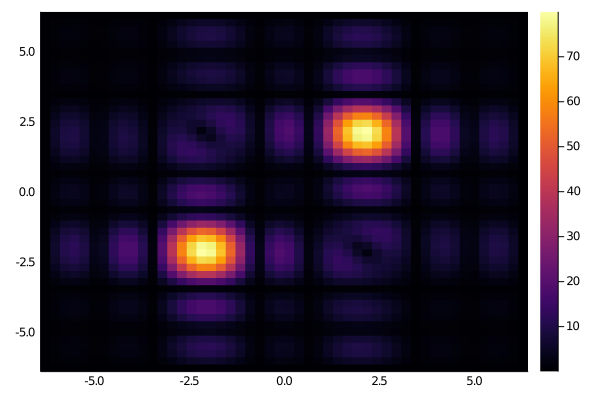

In [161]:
num_q = 50
q1s = LinRange(0, 1, num_q)
q2s = LinRange(0, 1, num_q)
ss_val = Float64[]
for i in 1:num_q,j in 1:num_q
	q = q1s[i]*b1 + q2s[j]*b2
    sq = compute_sq((q[1],q[2]), spin_pos_rs, sisj, triangles, 1, 1)
	push!(ss_val, abs(sq))
end
heatmap(qxs,qys,reshape(ss_val', num_q, num_q)) 

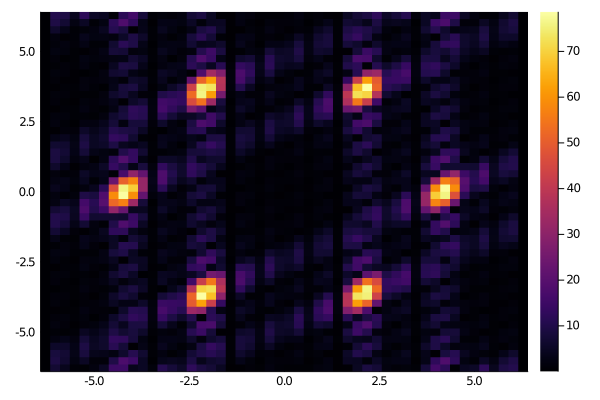

In [162]:
num_q = 50
qmax = 2π
qxs = LinRange(-qmax, qmax, num_q)
qys = LinRange(-qmax, qmax, num_q)

ss_val = Float64[]
for i in 1:num_q,j in 1:num_q
	sq = compute_sq((qxs[i],qys[j]), spin_pos_rs, sisj, triangles, 1, 1)
	push!(ss_val, abs(sq))
end
heatmap(qxs,qys,reshape(ss_val', num_q, num_q)) 

モンテカルロ計算の結果：$J_2>0, L=9$

In [156]:
fid = h5open("2d_out.h5","r")
sisj_mc = fid["sisj/mean"][:,:,:,1]
size(sisj)

(243, 3, 1)

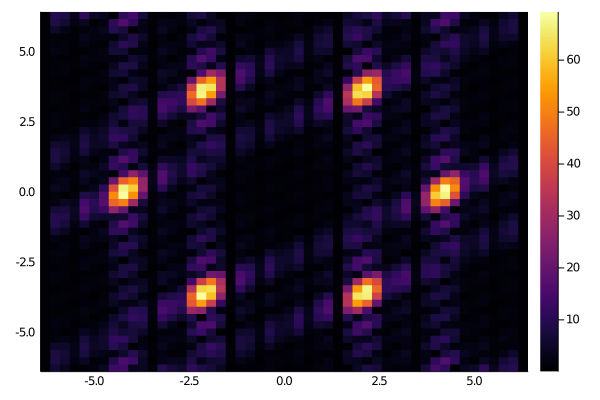

In [163]:
num_q = 50
qmax = 2π
qxs = LinRange(-qmax, qmax, num_q)
qys = LinRange(-qmax, qmax, num_q)

ss_val = Float64[]
for i in 1:num_q,j in 1:num_q
	sq = compute_sq((qxs[i],qys[j]), spin_pos_rs, sisj_mc, triangles, 1, 1)
	push!(ss_val, abs(sq))
end
heatmap(qxs,qys,reshape(ss_val', num_q, num_q)) 